In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
import sys

sys.path.append('../')

import csv
import numpy as np
import sys
import scipy.ndimage as nd
import json
import pickle
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from models.resnet import *
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import time
import math
from utils.utils import AverageMeter
from datasets.FattyLiverDatasets import FattyLiverClsDatasetsDiff3D 
from train.train_3d_cls2 import test

import torch.nn.functional as F

import scipy.ndimage as nd
import json
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
config_file = '../config/config_diff_3d.json'
with open(config_file,encoding='gb2312') as f:
    config = json.load(f)
config

{'train_list_file': '',
 'val_list_file': '',
 'test_list_file': '',
 'model_dir': '../data/experiment_0/9.model_3d_cls5_exp1',
 'num_classes': 5,
 'phase': 'train',
 'model': 'resnet34',
 'weight': None,
 'lr': 0.001,
 'mom': 0.9,
 'wd': 0.0001,
 'fix': 50,
 'step': 20,
 'epoch': 120,
 'display': 100,
 'num_workers': 8,
 'batch_size': 12,
 'dim_z': 128,
 'dim_x': 128,
 'optimizer': 'sgd'}

In [3]:
batch_size = 2
num_workers = 4
phase = 'train'
epochs = 10000
display = 2
crop_size = [32, 384, 512]

In [4]:
model = resnet34(num_classes=2, 
                 shortcut_type=True, 
                 sample_size_y=crop_size[1], 
                 sample_size_x=crop_size[2], sample_duration=crop_size[0])


pretrained_weights = '../data/experiment_0/9.model_cls2_exp1/ct_pos_recogtion_20200819110631/ct_pos_recognition_0047_best.pth'
# pretrained_weights = '../data/experiment_0/9.model_cls2_exp1/ct_pos_recogtion_20200820103204/ct_pos_recognition_0007_best.pth'
# pretrained_weights = '../data/experiment_0/9.model_cls2_exp1/ct_pos_recogtion_20200820135922/ct_pos_recognition_0022_best.pth'


# pretrained_weights = '../data/z16_zhenni_Fattyliver_v3_cls2/cut_diff_Fattyliver/cut_diff_0.7058823529411765_13_Fattyliver.pth'

model.load_state_dict(torch.load(pretrained_weights))

../models/resnet.py:233: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


<All keys matched successfully>

In [5]:
data_root = '../data/experiment_0/0.ori'
config_test = '../data/config/config_test.txt'
test_ds = FattyLiverClsDatasetsDiff3D(data_root, config_test,crop_size)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                                    num_workers=num_workers, pin_memory=False)

====> fatty liver count is:34


In [6]:
criterion = nn.CrossEntropyLoss().cuda()
acc, logger, tot_pred, tot_label, tot_prob = test(test_dataloader, nn.DataParallel(model).cuda(), criterion, 0, 10)
print(acc)
print(tot_prob)

../train/train_3d_cls2.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  tot_prob = np.append(tot_prob, F.softmax(output).cpu().detach().numpy()[:,1])


Epoch: [0][9/17]	Time 0.237535 (0.352)	Data 0.120	Loss 0.6002	Accuray 0.7000
[1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0]
[0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1]
0.6470588235294118
[0.6671577  0.6869531  0.6983471  0.6684198  0.6366509  0.62170047
 0.04197428 0.7231396  0.68549615 0.37542126 0.665246   0.66095155
 0.480715   0.5554771  0.71961194 0.681476   0.6624506  0.670464
 0.68455213 0.6663302  0.67805034 0.6729407  0.7314321  0.6793031
 0.6187528  0.6829619  0.67932475 0.6393793  0.14816876 0.67246497
 0.65281785 0.6831441  0.35867003 0.1281254 ]


In [7]:
def acu_curve(y,prob):
    from sklearn import metrics
    fpr,tpr,threshold = metrics.roc_curve(y,prob) ###计算真正率和假正率
    roc_auc = metrics.auc(fpr,tpr) ###计算auc的值
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic test')
    plt.legend(loc="lower right")
 
    plt.show()


def plot_roc(y_true, y_pred, class_name='dr'):
    print('\n====> plot {} info:\n'.format(class_name))
    log = []
    from sklearn import metrics
    def calc_metrics_table(y_true, y_pred, thresholds):
        metrics_list = list()
        for threshold in thresholds:
            y_pred_binary = np.zeros(y_pred.shape, dtype=np.uint8)
            y_pred_binary[y_pred>threshold] = 1
            tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred_binary).ravel()
#             print('tn:{:.3f}\tfp:{:.3f}\tfn:{:.3f}\ttp:{:.3f}\t'.format(tn, fp, fn, tp))
            accuracy = (tp+tn)/(tn+fp+fn+tp)
            sensitivity = tp/(tp+fn)
            specificity = tn/(fp+tn)
            ppv = tp/(tp+fp)
            npv = tn/(tn+fn)
            metrics_list.append([threshold, accuracy, sensitivity, specificity, ppv, npv])
        metrics_table = pd.DataFrame(np.array(metrics_list), columns=['threshold','accuracy','sensitivity','specificity','ppv','npv'])
        return metrics_table


    fpr, tpr, thres = metrics.roc_curve(y_true, y_pred)
    print('fpr\t\t\t','tpr')
    for i in range(len(fpr)):
        print(fpr[i],'\t',tpr[i])

    auc = metrics.auc(fpr, tpr)

    thresholds = np.arange(0.01, 1., 0.01)
    metrics_table = calc_metrics_table(y_true, y_pred, thresholds)

    print('\nAUC:%.4f\n'% auc)
    log.append('AUC:%.4f'% auc)

#     plt.figure()
#     plt.title('{} roc curve'.format(class_name))
#     plt.plot(fpr, tpr, 'r')
#     plt.xlabel('fpr')
#     plt.ylabel('tpr')
#     plt.xticks(np.arange(0, 1.1, step=0.1))
#     plt.yticks(np.arange(0, 1.1, step=0.1))
#     plt.grid(ls='--')
#     plt.show()
    acu_curve(y_true, y_pred)

    print(metrics_table)
    log.append(metrics_table)
    
#     metrics_table.to_csv('/home/zhangwd/code/work/FattyLiver_Solution/train/Val_0.7.csv')

    return log


====> plot fatty liver classification 2 info:

fpr			 tpr
0.0 	 0.0
0.07142857142857142 	 0.0
0.07142857142857142 	 0.3
0.14285714285714285 	 0.3
0.14285714285714285 	 0.7
0.5 	 0.7
0.5 	 0.75
0.6428571428571429 	 0.75
0.6428571428571429 	 0.8
0.7142857142857143 	 0.8
0.7142857142857143 	 0.9
0.9285714285714286 	 0.9
0.9285714285714286 	 1.0
1.0 	 1.0

AUC:0.7000



/home/zhangwd/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars
/home/zhangwd/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


<Figure size 432x288 with 0 Axes>

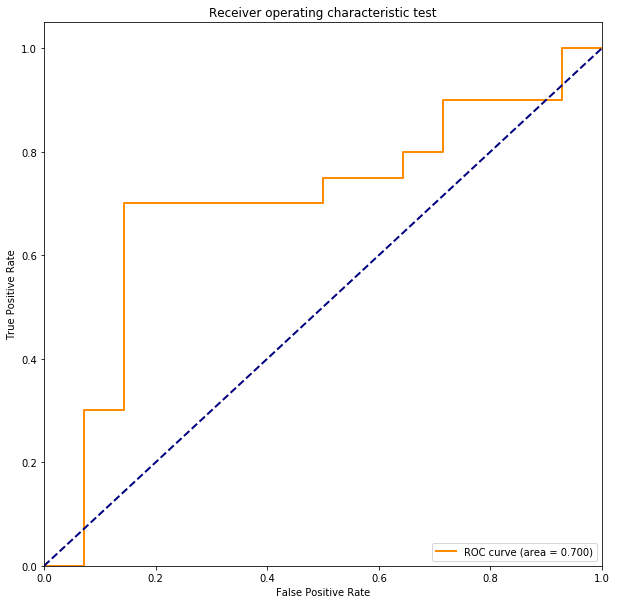

    threshold  accuracy  sensitivity  specificity       ppv       npv
0        0.01  0.588235          1.0     0.000000  0.588235       NaN
1        0.02  0.588235          1.0     0.000000  0.588235       NaN
2        0.03  0.588235          1.0     0.000000  0.588235       NaN
3        0.04  0.588235          1.0     0.000000  0.588235       NaN
4        0.05  0.617647          1.0     0.071429  0.606061  1.000000
..        ...       ...          ...          ...       ...       ...
94       0.95  0.411765          0.0     1.000000       NaN  0.411765
95       0.96  0.411765          0.0     1.000000       NaN  0.411765
96       0.97  0.411765          0.0     1.000000       NaN  0.411765
97       0.98  0.411765          0.0     1.000000       NaN  0.411765
98       0.99  0.411765          0.0     1.000000       NaN  0.411765

[99 rows x 6 columns]


In [8]:
log = plot_roc(np.array(tot_label, dtype=np.float32), np.array(tot_prob), 'fatty liver classification 2')

In [14]:
from sklearn.metrics import roc_auc_score

y_true = np.array(tot_label, dtype=np.float32)
y_pred = np.array(tot_prob)

n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred), len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
#     print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.495 - 0.879]


In [20]:
import pandas as pd
df = pd.DataFrame({'gt':y_true, 'pred':y_pred})
df.to_csv('./wtf.csv')

array([0.6671577 , 0.6869531 , 0.6983471 , 0.6684198 , 0.6366509 ,
       0.62170047, 0.04197428, 0.7231396 , 0.68549615, 0.37542126,
       0.665246  , 0.66095155, 0.480715  , 0.5554771 , 0.71961194,
       0.681476  , 0.6624506 , 0.670464  , 0.68455213, 0.6663302 ,
       0.67805034, 0.6729407 , 0.7314321 , 0.6793031 , 0.6187528 ,
       0.6829619 , 0.67932475, 0.6393793 , 0.14816876, 0.67246497,
       0.65281785, 0.6831441 , 0.35867003, 0.1281254 ], dtype=float32)